
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [20]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from agents.beacs import BEACS, BEACSConfiguration

# Load Metrics
from my_examples.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_eps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from my_examples.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gymnasium as gym
import gymnasium_mazes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Agent - BEACS

## Common parameters

In [ ]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "Woods100-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 1000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
ENABLE_EP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

#CRACS Set Up
APPLY_CRACS = True

#Seed
SEED = 42

## Environment - Maze

In [22]:
# Initialize environment
maze = gym.make(MAZE, slippery_prob=SLIPPERY_PROB)
# Reset it, by putting an agent into random position
maze.reset(seed=SEED)
# Render the current state of maze environment
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ A ■ □ $ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


/Users/romain/miniconda3/envs/test/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


## Training of BEACS - Exploration

In [23]:
%%time
#%%prun -l 0.5 -T profiling.txt

cfg_explore = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_ep=ENABLE_EP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES,
    seed=SEED
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

/Users/romain/miniconda3/envs/test/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


CPU times: user 3.24 s, sys: 52.9 ms, total: 3.29 s
Wall time: 3.27 s


### Performance

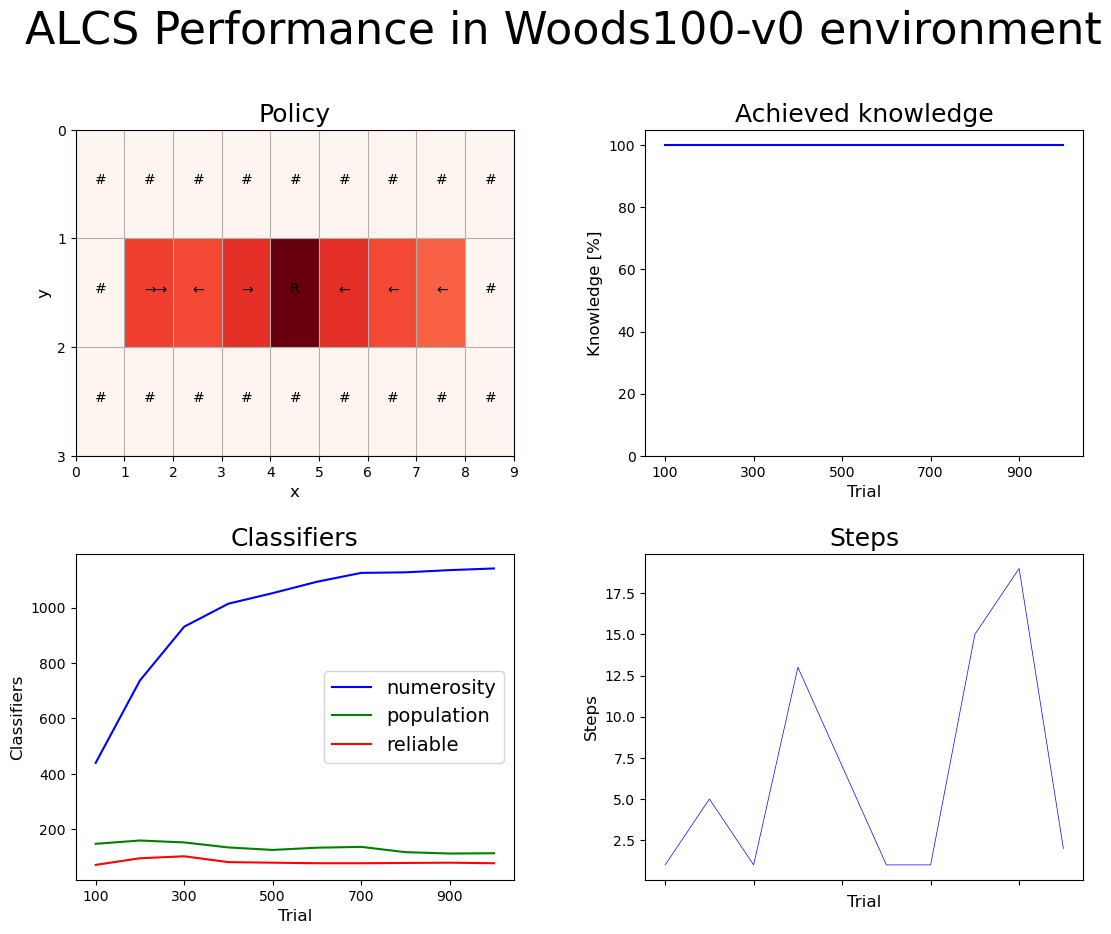

In [24]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None)
plot_performance(agent_explore, maze, metrics_df, MAZE, metrics_trial_frequency_explore, None)

In [25]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_eps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
ep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH)
print("Accumulated Error on PEP Probabilities :", ep_error, "%\n")

if APPLY_CRACS:
    agent_explore.apply_CRACS()
    population_explore = agent_explore.get_population()

print("There are ", _how_many_eps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
ep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH)
print("Accumulated Error on PEP Probabilities :", ep_error, "%")

Full knowledge was achieved at trials  100 , was stable at  100  and the last time it was achieved at  1000
There are  60  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 100.0, 'population': 114, 'numerosity': 1141, 'reliable': 78}
Mean reliable population specifity is  (0.1907051282051282, 0.1810344827586207, 0.21875)
Accumulated Error on PEP Probabilities : 0.6691484482734987 %

There are  43  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 100.0, 'population': 71, 'numerosity': 967, 'reliable': 54}
Mean reliable population specifity is  (0.16898148148148148, 0.153125, 0.21428571428571427)
Accumulated Error on PEP Probabilities : 0.6080983946944866 %


In [26]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

C:#.#.#.#.#.#.9.# A:6 None E:(#.#.#.#.#.#.0.#:357, #.#.#.#.#.#.#.#:70)
q: 1.0    r: 989.1  r_bis: 982.8  ir: 800.3  f: 989.1  err: 22.78 
exp: 412   num: 12 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, False, True] Aliased_state: 1.1.0.1.1.1.9.1 PAI_state: 
tga: 14492 tbseq: 13513 talp: 14494 tav: 24.32  



C:#.#.9.#.#.#.#.# A:2 None E:(#.#.0.#.#.#.#.#:384, #.#.#.#.#.#.#.#:65)
q: 1.0    r: 982.5  r_bis: 988.4  ir: 830.3  f: 988.4  err: 25.22 
exp: 418   num: 13 ee: False
Mark: empty Can_be_generalized: [True, True, False, True, True, True, True, True] Aliased_state: 1.1.9.1.1.1.0.1 PAI_state: 
tga: 14364 tbseq: 14349 talp: 14378 tav: 16.26  



C:#.#.0.#.#.#.1.# A:2 [2] E:(#.#.9.#.#.#.0.#:226, #.#.#.#.#.#.0.#:110, #.#.#.#.#.#.#.#:26)
q: 1.0    r: 901.6  r_bis: 917.3  ir: 0.0    f: 909.4  err: 41.32 
exp: 350   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, False, True, True, True, False, True] Aliased_state: 1.1.0.1.1.1.1.1 PAI_state: 

In [27]:
agent_explore.get_pai_states_memory()

[('1', '1', '0', '1', '1', '1', '0', '1')]

## Training of BEACS - Exploitation

In [28]:
%%time

cfg_exploit_no_rl = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2,
    seed=SEED
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 266 ms, sys: 4.46 ms, total: 270 ms
Wall time: 228 ms


In [29]:
%%time

cfg_exploit_rl_start = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0,
    seed=SEED
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 199 ms, sys: 3.47 ms, total: 203 ms
Wall time: 202 ms


In [30]:
%%time

cfg_exploit_rl = BEACSConfiguration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
    seed=SEED
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 199 ms, sys: 3.05 ms, total: 202 ms
Wall time: 201 ms


### Performance

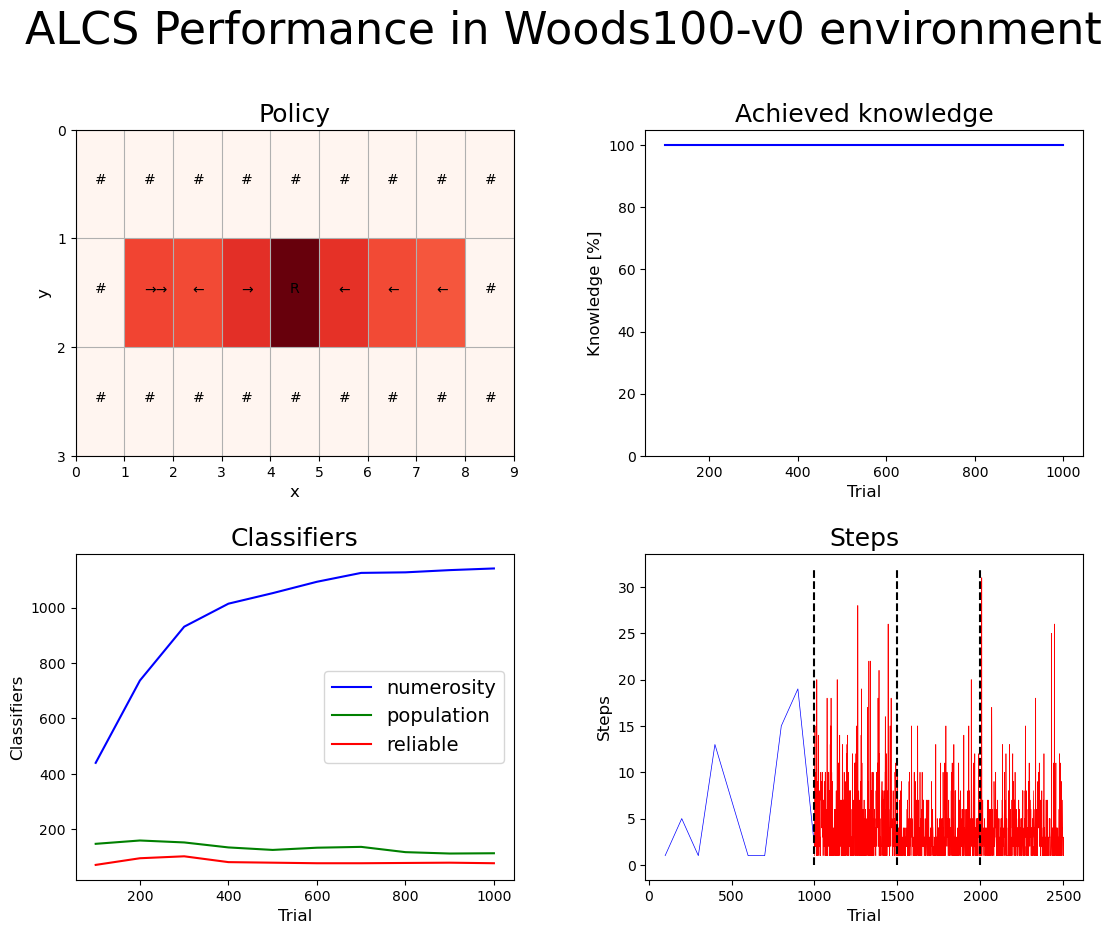

In [31]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [32]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  6.5  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  4.774  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  3.368  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  3.606  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 100.0, 'population': 71, 'numerosity': 967, 'reliable': 54}
{'knowledge': 100.0, 'population': 71, 'numerosity': 967, 'reliable': 54}
{'knowledge': 100.0, 'population': 71, 'numerosity': 967, 'reliable': 54}
{'knowledge': 100.0, 'population': 71, 'numerosity': 967, 'reliable': 54}


In [33]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl if cl.is_reliable()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

54


C:#.#.9.#.#.#.#.# A:2 None E:(#.#.0.#.#.#.#.#:1888, #.#.#.#.#.#.#.#:65)
q: 1.0    r: 984.3  r_bis: 991.0  ir: 758.3  f: 991.0  err: 19.52 
exp: 418   num: 13 ee: False
Mark: empty Can_be_generalized: [True, True, False, True, True, True, True, True] Aliased_state: 1.1.9.1.1.1.0.1 PAI_state: 
tga: 14364 tbseq: 14349 talp: 14378 tav: 16.26  



C:#.#.#.#.#.#.9.# A:6 None E:(#.#.#.#.#.#.0.#:1861, #.#.#.#.#.#.#.#:70)
q: 1.0    r: 980.9  r_bis: 981.7  ir: 765.0  f: 981.7  err: 28.85 
exp: 412   num: 12 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, False, True] Aliased_state: 1.1.0.1.1.1.9.1 PAI_state: 
tga: 14492 tbseq: 13513 talp: 14494 tav: 24.32  



C:#.#.0.#.#.#.1.# A:2 [2] E:(#.#.9.#.#.#.0.#:226, #.#.#.#.#.#.0.#:110, #.#.#.#.#.#.#.#:26)
q: 1.0    r: 886.2  r_bis: 901.3  ir: 0.0    f: 893.8  err: 52.3  
exp: 350   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, False, True, True, True, False, True] Aliased_state: 1.1.0.1.1.1.1.1 PAI_